In [1]:
! pip install tensorflow-text -q
! pip3 install tf-models-official -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.9.2 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.26.0 which is incompatible.
flax 0.6.0 requires rich~=11.1, but you have rich 12.1.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
pandas-profiling 3.1.0 requires markupsafe~=2.0.1, but you have markupsafe 2.1.1 which is incompatible.
flax 0.6.0 requires rich~=11.1, but you have rich 12.1.0 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 w

In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow import keras
from keras import models, layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
# for BERT
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization # to create AdamW optimizer

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [4]:
# load the dataset
train = pd.read_csv('../input/feedback-prize-english-language-learning/train.csv')
test = pd.read_csv('../input/feedback-prize-english-language-learning/test.csv')

In [5]:
# choose a BERT Model to use
bert_model = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/2'
preprocessor_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [6]:
def build_model():
    text_input = layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessor = hub.KerasLayer(handle=preprocessor_path, trainable=False, name='preprocessor')
    encoder_inputs = preprocessor(text_input)
    
    bert = hub.KerasLayer(handle=bert_model, trainable=True, name='BERT')
    outputs = bert(encoder_inputs)
    net = outputs['pooled_output']
    net = layers.Dropout(0.1)(net)
    
    net = layers.Dense(6)(net)
    model = keras.Model(inputs = text_input, outputs = net)
    return model

In [7]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

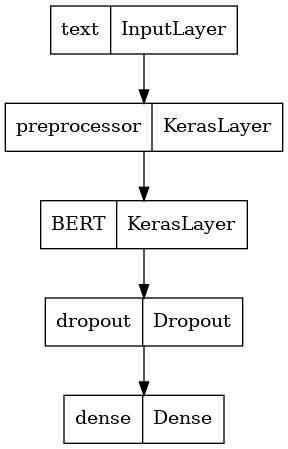

In [8]:
tf.keras.utils.plot_model(model)

In [9]:
# define the loss, metrics and optimizer
epochs = 20
dataset = tf.data.Dataset.range(1000)
steps_per_epoch = tf.data.experimental.cardinality(dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [10]:
model.compile(loss='mse', optimizer=optimizer, metrics='acc')

In [11]:
inputs = train['full_text'].values.tolist()
targets = train[['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions']].values.tolist()

In [12]:
history = model.fit(x=inputs, y=targets, epochs=epochs)

Epoch 1/20
123/123 [==============================] - 65s 365ms/step - loss: 7.2015 - acc: 0.0928
Epoch 2/20
123/123 [==============================] - 45s 365ms/step - loss: 0.5550 - acc: 0.1785
Epoch 3/20
123/123 [==============================] - 44s 362ms/step - loss: 0.3959 - acc: 0.1930
Epoch 4/20
123/123 [==============================] - 45s 364ms/step - loss: 0.3501 - acc: 0.2086
Epoch 5/20
123/123 [==============================] - 45s 362ms/step - loss: 0.3305 - acc: 0.2020
Epoch 6/20
123/123 [==============================] - 45s 366ms/step - loss: 0.3123 - acc: 0.2023
Epoch 7/20
123/123 [==============================] - 45s 364ms/step - loss: 0.2876 - acc: 0.2043
Epoch 8/20
123/123 [==============================] - 44s 361ms/step - loss: 0.2706 - acc: 0.2212
Epoch 9/20
123/123 [==============================] - 45s 367ms/step - loss: 0.2448 - acc: 0.2232
Epoch 10/20
123/123 [==============================] - 45s 364ms/step - loss: 0.2208 - acc: 0.2401
Epoch 11/20
123/123

In [13]:
inputs = test['full_text'].values.tolist()

predictions = model.predict(inputs)
predictions = predictions.tolist()

1/1 [==============================] - 1s 995ms/step


In [14]:
predictions[0]

[3.0357275009155273,
 3.0878922939300537,
 3.302969217300415,
 3.4684555530548096,
 3.1138548851013184,
 2.8328654766082764]

In [15]:
submission = pd.DataFrame(predictions, columns=['cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions'])
submission = pd.concat([test['text_id'], submission], axis=1)
submission

,text_id,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,3.035728,3.087892,3.302969,3.468456,3.113855,2.832865
1,000BAD50D026,2.692861,2.659956,2.704759,2.644668,2.258977,2.678216
2,00367BB2546B,3.953187,3.827868,3.929414,3.800150,3.629714,4.054071


In [16]:
submission.to_csv('submission.csv', index=False)